# How to Subset and Download Level 2, 3, and 4 GES DISC Data Using Harmony-py

### Overview

This notebook uses the `harmony-py` library to query, subset, and download Level 2 and Level 3/4 GES DISC Granules from the Harmony Subsetter. The notebook is split in two parts: the first demonstrates subsetting a MERRA-2 granule (Level 4), and the second demonstrates subsetting a JPSS granule (Level 2). Harmony allows GES DISC users to subset their data remotely before it is returned to the user, rather than loading data from a remote source and subsetting it inside the notebook.

The Harmony subsetting services called in this notebook are not to be confused with the Giovanni Time Series Service or Averaging Services, which are also accessible through Harmony-py. To access those services, please visit [this how-to](). 

This notebook was written using Python 3.10, and requires these libraries and files:

- Earthdata Login Account: https://urs.earthdata.nasa.gov/users/new
- [Harmony-py](https://harmony-py.readthedocs.io/en/main/)
- [xarray](https://docs.xarray.dev/en/stable/) (must be >=2025.4.0)
- [earthaccess](https://earthaccess.readthedocs.io/en/latest/quick-start/)

### Contents
* [Section 1: Searching and Subsetting Level 3/4 Collections](#download_full_granules)

* [Section 2: Searching and Subsetting Level 2 Collections](#stream_full_granules)

#### Anaconda Environment YAML:

This notebook can be run using the ['nasa-gesdisc' YAML file](https://github.com/nasa/gesdisc-tutorials/tree/main/environments/nasa-gesdisc.yml) provided in the 'environments' subfolder.

Please follow the instructions [here](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file) to install and activate this environment. 


### Quick Recap: What are Level 2, 3, and 4 Collections?

NASA Earthdata collections are separated into "[processing levels](https://www.earthdata.nasa.gov/learn/earth-observation-data-basics/data-processing-levels)", on a scale from levels 0-4. The Harmony service will subset select level 2, 3, and 4 collections from various DAACs, which can be searched and filtered using the Common Metadata Repository, or Earthdata Search, in addition to information posted on the collection's dataset landing page.

---

# Initial Setup

#### Import Libraries

In [31]:
from harmony import Dimension, Client, Collection, Request, BBox
from datetime import datetime
import earthaccess
import xarray as xr
import os
from IPython.display import Image, display
%matplotlib inline

#### Create Client using Earthdata Login Credentials

This section will prompt the user for their Earthdata Login username and password and save them to a `.netrc` file if it does not already exist.

Then, a Harmony Client object is created, using the credentials inside the `.netrc` file.

In [32]:
# Prompt for Earthdata Login credentials, store in a .netrc file if it does not exist
auth = earthaccess.login(strategy="interactive", persist=True)

harmony_client = Client()

---

# Section 1: Searching and Subsetting Level 3/4 Collections

### 1. Search for Harmony-Enabled Level 3/4 Collections

1a. Check if your desired Level 3/4 GES DISC collection is enabled in Harmony by visiting this Earthdata Search link: [Level 3/4 Harmony-Enabled GES DISC Collections](https://search.earthdata.nasa.gov/search?ff=Customizable&fdc=Goddard%2BEarth%2BSciences%2BData%2Band%2BInformation%2BServices%2BCenter%2B%2528GES%2BDISC%2529&fl=3%2B-%2BGridded%2BObservations!4%2B-%2BGridded%2BModel%2BOutput). 

1b. Select and copy the "Short name" and version number. In the figure below, these can be found inside the orange box, or by clicking the button inside the blue box:

![Earthdata Search figure highlighting the shortname and version](data:image/png;base64,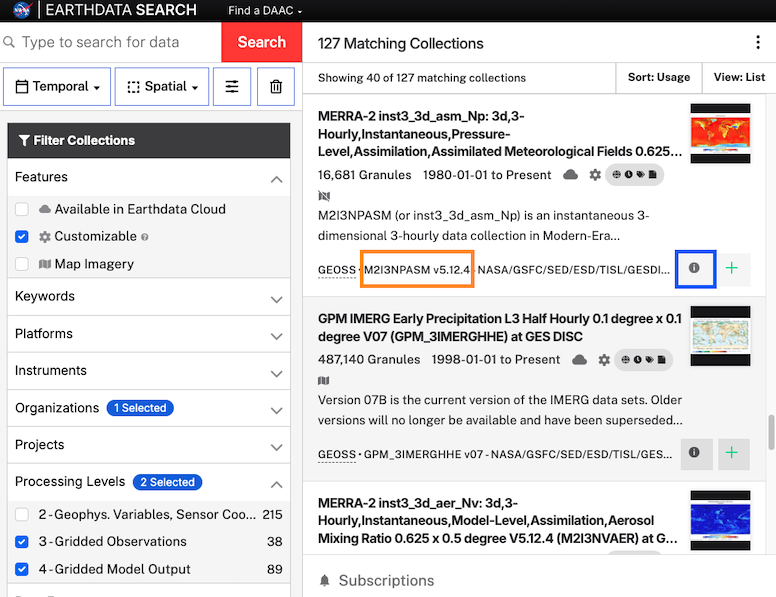)


### 2a. Specify Collection and Spatiotemporal Subsetting Parameters

The collection short name and version numbers must be specified, along with a bounding box and time range.

In [33]:
# Enter collection short name
short_name = "M2I3NPASM"

# Enter collection version number (as a string)
version = "5.12.4"

# Define the spatial bounding box to be clipped
bbox = BBox(-95, 20, -75, 35)  # (west, south, east, north)

# Specify the start and end times in UTC
start = datetime(2005, 8, 28, 0, 0) # (year, month, day, hour, minute)
stop = datetime(2005, 8, 29, 18, 0)

### 3b. Specify Dimension and Variable Subsetting Parameters
 
_This step can be skipped if additional subsetting is not desired or if the Level 3 or 4 collection does not contain additional dimensions outside of `lat`, `lon`, and `time`._

Some Level 3 and 4 collections may include additional dimensions (i.e, vertical dimensions such as pressure and altitude). To subset along these additional dimensions, users will need to utilize Harmony-py's `Dimension` function to create those request(s). 

The Dimension function takes the arguments of the dimension's name, for the M2I3NPASM MERRA-2 collection the `lev` dimension contains the pressure levels. Then the range needs to be specified, in this case the `lev` dimension is in units of hectopascals (hPa). 

To individually stride levels, please refer to step 7 of this section.
Only a range of actual dimensional values must be passed, instead of individually selecting the indices of the levels (otherwise known as "striding"). 

In [34]:
# Specify 1000-850 hPa pressure levels.
lev_dimension = Dimension(name='lev', min=850, max=1000)

Collections can be further subsetted by specifying a list of variable names as shown below.

In [35]:
# Enter variables to be subsetted
variables = ["T", "U", "V"]

### 4. Submit Request

We will create a Request object, check if it is valid, and submit the request. The request will not be downloaded until the following cell.

Once the request is completed without errors, we can print a URL showing the full subset that can be queried using tools like `wget` or `curl`, and we can print the size of the output files before we download them.

In [36]:
temporal = {
    "start": start,
    "stop": stop
}

# Query the CMR for the collection concept ID
concept_id = earthaccess.search_datasets(short_name=short_name, version=version)[0].concept_id()

# Build request
request = Request(
    collection=Collection(concept_id),
    spatial=bbox,
    temporal=temporal,
    dimensions=[lev_dimension],
    variables=variables
)

try:
    # Check if the request syntax is valid
    if not request.is_valid():
        print("Local validation error:", request.validation_messages)
    else:
        # Submit the request and monitor progress, outputting request URLs and the data size
        job_id = harmony_client.submit(request)
        harmony_client.wait_for_processing(job_id, show_progress=True)
        job_summary = harmony_client.result_json(job_id)
        print("Request URL:", job_summary["request"])
        print("Output Data Size:", job_summary["outputDataSize"])

except Exception as e:
    print("Harmony request failed:", e)


 [ Processing: 100% ] |###################################################| [|]


Request URL: https://harmony.earthdata.nasa.gov/C1276812879-GES_DISC/ogc-api-coverages/1.0.0/collections/parameter_vars/coverage/rangeset?forceAsync=true&subset=lat(20%3A35)&subset=lon(-95%3A-75)&subset=time(%222005-08-28T00%3A00%3A00%22%3A%222005-08-29T18%3A00%3A00%22)&subset=lev(850%3A1000)&label=harmony-py&variable=T&variable=U&variable=V
Output Data Size: 891.67 KiB


### 5. Download Subsets

Harmony-py will download the files in their oriignal data format, which in this example, is NetCDF4. Here, we specify the directory to download the subsetted files to, setting `overwrite=False` to skip overwriting existing files.

In [37]:
# Specify download directory
directory = "./M2I3NPASM_Subsets"

# Create directory if it doesn’t exist
os.makedirs(directory, exist_ok=True)

# Download subsetted files asynchronously
futures = harmony_client.download_all(job_id, directory=directory, overwrite=False)

# Print file paths
filelist = [f.result() for f in futures]

./M2I3NPASM_Subsets/120403572_M2I3NPASM.5.12.4_MERRA2_300.inst3_3d_asm_Np.20050828_subsetted.nc4
./M2I3NPASM_Subsets/120403573_M2I3NPASM.5.12.4_MERRA2_300.inst3_3d_asm_Np.20050829_subsetted.nc4


### 6. Stride Dimensions using Xarray and Save as NetCDF4

To individually select pressure levels (striding), use the Xarray [`.sel()`](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.sel.html) function. Below, we select three pressure levels, rendering a new dataset called `ds_stride` with a corresponding `lev` dimension length of three.

In [15]:
# Open and concatenate all files in the directory
ds = xr.open_mfdataset(directory + "/*.nc4")

# Select and stride pressure levels
ds_stride = ds.sel(lev=[850, 900, 1000])
print(ds_stride)

# Save to a NetCDF4 file
ds_stride.to_netcdf(directory + "/M2I3NPASM_Stride_Levs.nc4")

<xarray.Dataset> Size: 553kB
Dimensions:  (time: 15, lev: 3, lat: 31, lon: 33)
Coordinates:
  * time     (time) datetime64[ns] 120B 2005-08-28 ... 2005-08-29T18:00:00
  * lat      (lat) float64 248B 20.0 20.5 21.0 21.5 22.0 ... 33.5 34.0 34.5 35.0
  * lev      (lev) float64 24B 850.0 900.0 1e+03
  * lon      (lon) float64 264B -95.0 -94.38 -93.75 ... -76.25 -75.62 -75.0
Data variables:
    V        (time, lev, lat, lon) float32 184kB dask.array<chunksize=(8, 3, 31, 33), meta=np.ndarray>
    T        (time, lev, lat, lon) float32 184kB dask.array<chunksize=(8, 3, 31, 33), meta=np.ndarray>
    U        (time, lev, lat, lon) float32 184kB dask.array<chunksize=(8, 3, 31, 33), meta=np.ndarray>
Attributes: (12/37)
    History:                             Original file generated: Fri Nov  7 ...
    Comment:                             GMAO filename: d5124_m2_jan00.inst3_...
    Filename:                            MERRA2_300.inst3_3d_asm_Np.20050828.nc4
    Conventions:                       

---

# Section 2: Searching and Subsetting Level 2 Collections

### 1. Search for Harmony-Enabled Level 2 Collections

1a. Check if your desired Level 2 GES DISC collection is enabled in Harmony by visiting this Earthdata Search link: [Level 2 Harmony-Enabled GES DISC Collections](https://search.earthdata.nasa.gov/search?ff=Customizable&fdc=Goddard%2BEarth%2BSciences%2BData%2Band%2BInformation%2BServices%2BCenter%2B%2528GES%2BDISC%2529&fl=2%2B-%2BGeophys.%2BVariables%252C%2BSensor%2BCoordinates). 

1b. Select and copy the "Short name" and version number (demonstrated in Section 1, Step 1 of this notebook).

### 2a. Specify Collection and Spatiotemporal Subsetting Parameters

The collection short name and version numbers must be specified, along with a bounding box and time range.

Note that dimensional subsetting is ***not*** supported when subsetting Level 2 collections.

In [27]:
# Enter collection short name
short_name = "SNDRJ1IML2CCPRET"

# Enter version number (as a string)
version = "2"

# Define the spatial bounding box to be clipped
bbox = BBox(-100, 15, -75, 30)  # (west, south, east, north)

# Specify the start and end times in UTC
start = datetime(2021, 9, 23, 0, 0) # (year, month, day, hour, minute)
stop = datetime(2021, 9, 24, 0, 0)

Collections can be further subsetted by specifying a list of variable names as shown below.

In [28]:
# Enter variables to be subsetted
variables = ["surf_air_temp", "surf_air_temp_qc", "sol_zen", "lat", "lon"]

### 3. Submit Request

We will create a Request object, check if it is valid, and submit the request. The request will not be downloaded until the following cell.

Once the request is completed without errors, we can print a URL showing the full subset that can be queried using tools like `wget` or `curl`, and we can print the size of the output files before we download them.

In [29]:
temporal = {
    "start": start,
    "stop": stop
}

# Query the CMR for the collection concept ID
concept_id = earthaccess.search_datasets(short_name=short_name, version=version)[0].concept_id()

# Build request
request = Request(
    collection=Collection(concept_id),
    spatial=bbox,
    temporal=temporal,
    variables=variables
)

try:
    # Check if the request syntax is valid
    if not request.is_valid():
        print("Local validation error:", request.validation_messages)
    else:
        # Submit the request and monitor progress, outputting request URLs and the data size
        job_id = harmony_client.submit(request)
        harmony_client.wait_for_processing(job_id, show_progress=True)
        job_summary = harmony_client.result_json(job_id)
        print("Request URL:", job_summary["request"])
        print("Output Data Size:", job_summary["outputDataSize"])

except Exception as e:
    print("Harmony request failed:", e)

 [ Processing: 100% ] |###################################################| [|]


Request URL: https://harmony.earthdata.nasa.gov/C1692982090-GES_DISC/ogc-api-coverages/1.0.0/collections/parameter_vars/coverage/rangeset?forceAsync=true&subset=lat(15%3A30)&subset=lon(-100%3A-75)&subset=time(%222021-09-23T00%3A00%3A00%22%3A%222021-09-24T00%3A00%3A00%22)&label=harmony-py&variable=surf_air_temp&variable=surf_air_temp_qc&variable=sol_zen&variable=lat&variable=lon
Output Data Size: 796.97 KiB


### 4. Download Subsets

Harmony-py will download the files in their orignal data format (typically HDF5 or NetCDF). Conversion to other formats, like NetCDF4, [can be done using Xarray](https://docs.xarray.dev/en/latest/generated/xarray.Dataset.to_netcdf.html). Here, we specify the directory to download the subsetted files to, setting `overwrite=False` to skip overwriting existing files.

In [30]:
# Specify download directory
directory = "./JPSS_Subsets"

# Create directory if it doesn’t exist
os.makedirs(directory, exist_ok=True)

# Download subsetted files asynchronously
futures = harmony_client.download_all(job_id, directory=directory, overwrite=False)

# Print file paths
filelist = [f.result() for f in futures]

##### To aggregate and plot subsetted JPSS data, please visit the following how-to: [How to Find and Plot Level 2 Data from Multiple Granules on a Map Using Python](https://github.com/nasa/gesdisc-tutorials/blob/main/notebooks/How_to_Find_and_Plot_Level2_Data_from_Multiple_Granules_on_a_Map_Using_Python.ipynb)